In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt

os.getcwd()

'c:\\Users\\matte\\OneDrive\\Desktop\\Università\\Trieste\\Second_year\\HPC21\\Cozzini\\MPI\\Assignment1\\PingPong\\gpu_openMPI'

In [2]:
def comm_model(m_size, latency, rev_b):
	return rev_b * m_size + latency

def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)


def graph_and_fit_and_csv(filename, filename_out, list_nodes_involved, command_line_used):
    
    #loading data
    data_frame = pd.read_csv(filename)
    data_frame = data_frame.drop(columns=['Unnamed: 0'])
    data = data_frame.values

    # Plotting Effective bandwidth vs Number of bytes
    x, y = data[:, 0], data[:, 3]
    plt.figure()
    plt.scatter(x, y)
    plt.plot(x,y)
    plt.title(filename)
    plt.xscale("log")
    plt.xlabel("N [Bytes]")
    plt.ylabel("B [MBytes/sec]")
    plt.show()

    # Plotting and fitting Time vs Number of bytes
    x, y = data[:, 0], data[:, 2]
    popt, _ = curve_fit(comm_model, x, y)
    latency, rev_b = popt
    bandwidth = 1/rev_b
    #print('y = %.0f * x + %.2f' % (bandwidth, latency))
    plt.figure()
    plt.scatter(x, y)
    x_line = np.arange(min(x), max(x), 100000)
    y_line = comm_model(x_line, latency, rev_b)
    plt.plot(x_line, y_line, '-', color='red', label='fit: b = %.1f [bytes/us], latency = %.2f [us]' % ((bandwidth), latency))
    plt.title(filename)
    plt.xlabel("N [bytes]")
    plt.ylabel('Time '+r'$[\mu s]$')
    plt.legend()
    plt.show()

    # Adding cols to dataframe
    t = comm_model(x, latency, rev_b)
    t = np.round(t,2)
    Mbytes_second = np.round(np.divide(x, t),2)
    data_frame['t[usec] computed'] = t
    data_frame['Mbytes/sec computed'] = Mbytes_second

    # Creating output csv file
    data_frame.to_csv(filename_out,index=False)
    header_line_3 = f"#header_line 3: (latency, bandwidth) computed by fitting data = ({round(latency,2)},{round(1/rev_b,1)})"
    header_line_2 = f'#header_line 2: list of nodes involved: {list_nodes_involved}'
    header_line_1 = f'#header_line 1: command line used: {command_line_used}'

    line_prepender(filename_out, header_line_3)
    line_prepender(filename_out, header_line_2)
    line_prepender(filename_out, header_line_1)

## Cores

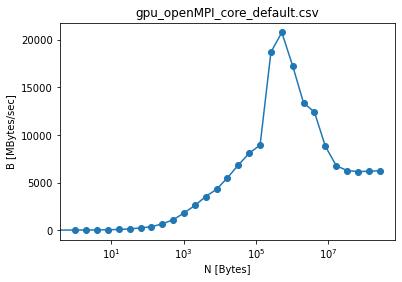

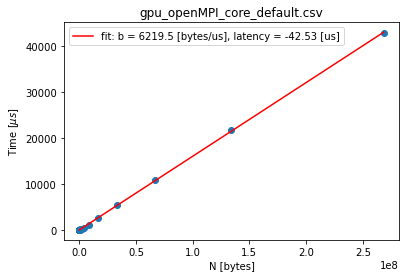

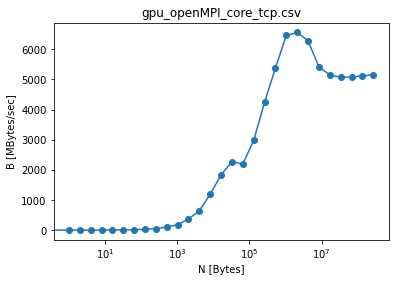

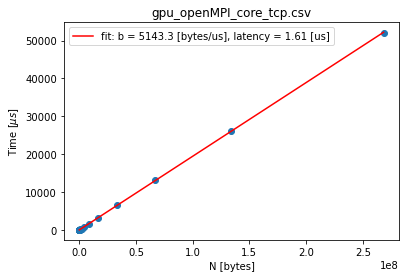

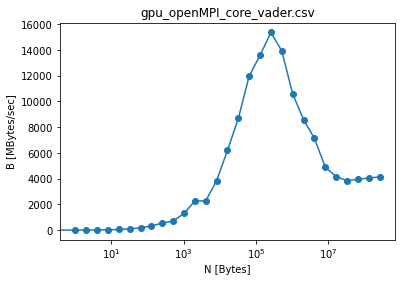

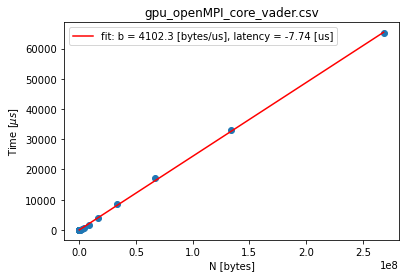

In [3]:
graph_and_fit_and_csv('gpu_openMPI_core_default.csv', 'gpu_openMPI_core_default_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by core --mca btl ^openib ./IMB-MPI1 PingPong -msglog 28')
graph_and_fit_and_csv('gpu_openMPI_core_tcp.csv', 'gpu_openMPI_core_tcp_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by core --mca pml ob1 --mca btl self,tcp ./IMB-MPI1 PingPong -msglog 28')
graph_and_fit_and_csv('gpu_openMPI_core_vader.csv', 'gpu_openMPI_core_vader_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by core --mca pml ob1 --mca btl self,vader ./IMB-MPI1 PingPong -msglog 28')

In [4]:
def together_plot(filenameList, plotTiltle):

    listOfDataframe = []

    for filename in filenameList:
        data_frame = pd.read_csv(filename)
        data_frame = data_frame.drop(columns=['Unnamed: 0'])
        data = data_frame.values
        listOfDataframe.append(data)

    x0, y0 = listOfDataframe[0][:, 0], listOfDataframe[0][:, 3]
    x1, y1 = listOfDataframe[1][:, 0], listOfDataframe[1][:, 3]
    x2, y2 = listOfDataframe[2][:, 0], listOfDataframe[2][:, 3]
    
    plt.figure()

    plt.scatter(x0, y0, marker='.')
    plt.plot(x0,y0, label = 'default')
    plt.scatter(x1, y1, marker='.')
    plt.plot(x1,y1, label='tcp')
    plt.scatter(x2, y2, marker='.')
    plt.plot(x2,y2, label='vader')
      
    plt.title(plotTiltle)
    plt.xscale("log")
    plt.xlabel("N [Bytes]")
    plt.ylabel(r'$B$'+' [MBytes/sec]')
    plt.legend()
    plt.show()
    #return listOfDataframe
        

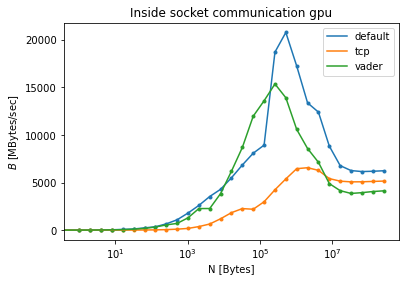

In [6]:
filenameList = ['gpu_openMPI_core_default.csv','gpu_openMPI_core_tcp.csv','gpu_openMPI_core_vader.csv']
pltT = 'Inside socket communication gpu'
together_plot(filenameList,pltT)


## Socket

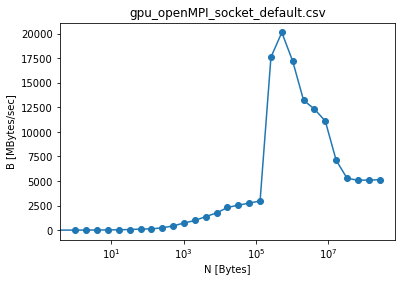

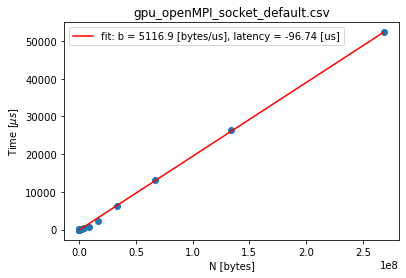

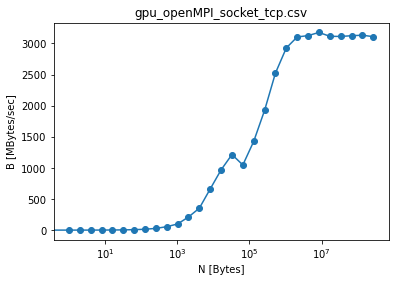

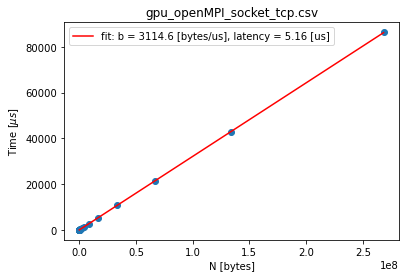

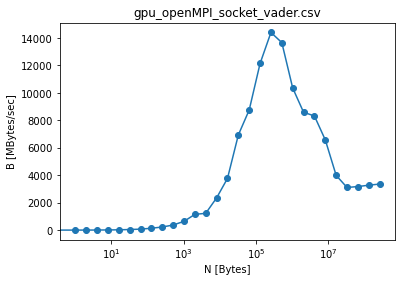

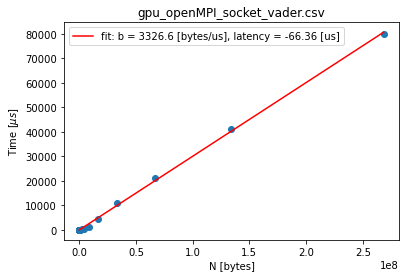

In [7]:
graph_and_fit_and_csv('gpu_openMPI_socket_default.csv', 'gpu_openMPI_socket_default_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by socket --mca btl ^openib ./IMB-MPI1 PingPong -msglog 28')
graph_and_fit_and_csv('gpu_openMPI_socket_tcp.csv', 'gpu_openMPI_socket_tcp_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by socket --mca pml ob1 --mca btl self,tcp ./IMB-MPI1 PingPong -msglog 28')
graph_and_fit_and_csv('gpu_openMPI_socket_vader.csv', 'gpu_openMPI_socket_vader_out.csv', 'ct1pg-gnode001', 'mpirun -np 2 --map-by socket --mca pml ob1 --mca btl self,vader ./IMB-MPI1 PingPong -msglog 28')

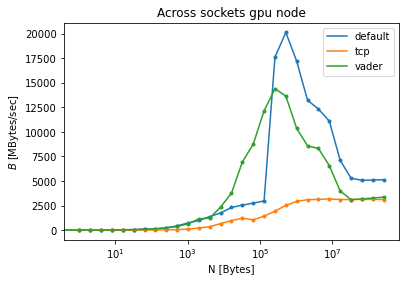

In [8]:
filenameList = ['gpu_openMPI_socket_default.csv','gpu_openMPI_socket_tcp.csv','gpu_openMPI_socket_vader.csv']
plotTitle = 'Across sockets gpu node'
together_plot(filenameList, plotTitle)

## Nodes

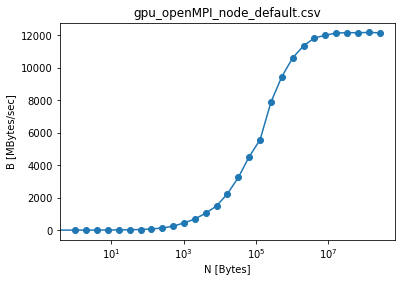

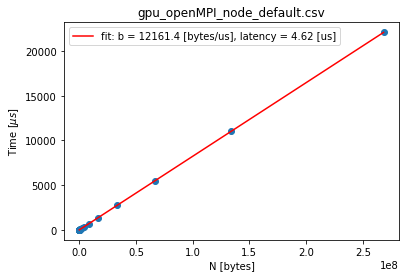

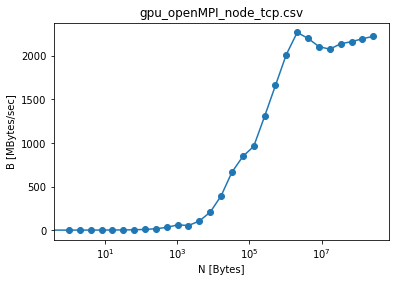

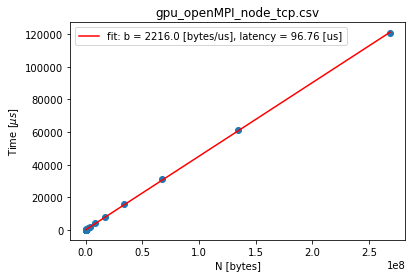

In [9]:
graph_and_fit_and_csv("gpu_openMPI_node_default.csv", "gpu_openMPI_node_default_out.csv", 'ct1pg-gnode001 + ct1pg-gnode003', "mpirun -np 2 --map-by node --mca btl ^openib ./IMB-MPI1 PingPong -msglog 28")
graph_and_fit_and_csv("gpu_openMPI_node_tcp.csv", "gpu_openMPI_node_tcp_out.csv", 'ct1pg-gnode001 + ct1pg-gnode003', "mpirun -np 2 --map-by node --mca pml ob1 --mca btl self,tcp ./IMB-MPI1 PingPong -msglog 28")

In [11]:
def together_plot_nodes(filenameList, plotTiltle):

    listOfDataframe = []

    for filename in filenameList:
        data_frame = pd.read_csv(filename)
        data_frame = data_frame.drop(columns=['Unnamed: 0'])
        data = data_frame.values
        listOfDataframe.append(data)

    x0, y0 = listOfDataframe[0][:, 0], listOfDataframe[0][:, 3]
    x1, y1 = listOfDataframe[1][:, 0], listOfDataframe[1][:, 3]
    
    #Plotting the bandwidth
    plt.figure()

    plt.scatter(x0, y0, marker='.')
    plt.plot(x0,y0, label = 'default')
    plt.scatter(x1, y1, marker='.')
    plt.plot(x1,y1, label='tcp')
      
    plt.title(plotTiltle)
    plt.xscale("log")
    plt.xlabel("N [Bytes]")
    plt.ylabel(r'$B$'+' [MBytes/sec]')
    plt.legend()
    plt.show()

    # Plotting the fit
    z0, p0 = listOfDataframe[0][:, 0], listOfDataframe[0][:, 2]
    z1, p1 = listOfDataframe[1][:, 0], listOfDataframe[1][:, 2]
    popt0, _ = curve_fit(comm_model, z0, p0)
    popt1, _ = curve_fit(comm_model, z1, p1)
    latency0, rev_b0 = popt0
    bandwidth0 = 1/rev_b0
    latency1, rev_b1 = popt1
    bandwidth1 = 1/rev_b1
    #print('y = %.0f * x + %.2f' % (bandwidth, latency))

    plt.figure()
    plt.scatter(z0, p0, marker='x', color='black', alpha=0.5)
    z0_line = np.arange(min(z0), max(z0), 100000)
    p0_line = comm_model(z0_line, latency0, rev_b0)
    plt.plot(z0_line, p0_line, '-', label='default: b = %.1f [bytes/us], latency = %.2f [us]' % ((bandwidth0), latency0))
    plt.scatter(z1, p1, color='black', marker='2', alpha=0.5)
    z1_line = np.arange(min(z1), max(z1), 100000)
    p1_line = comm_model(z1_line, latency1, rev_b1)
    plt.plot(z1_line, p1_line, '-', label='tcp:       b = %.1f [bytes/us], latency = %.2f [us]' % ((bandwidth1), latency1))



    plt.title("Communication time across nodes")
    plt.xlabel("N [bytes]")
    plt.ylabel('Time '+r'$[\mu s]$')
    plt.legend()
    plt.show()

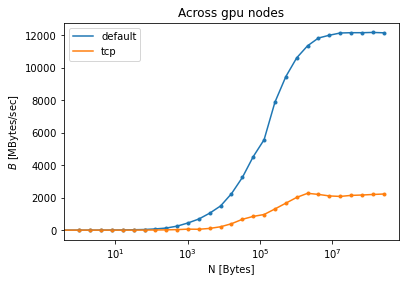

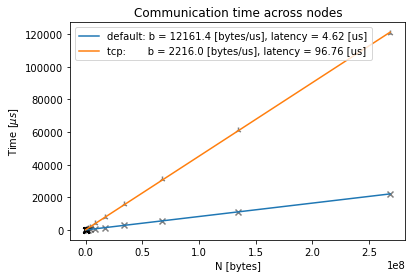

In [12]:
filenameList = ['gpu_openMPI_node_default.csv','gpu_openMPI_node_tcp.csv']
plotTitle = 'Across gpu nodes'
together_plot_nodes(filenameList, plotTitle)

(2685,)


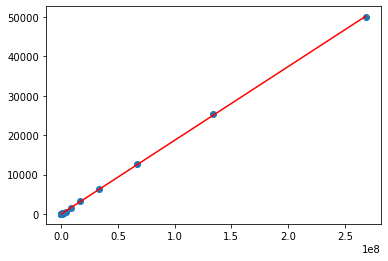

In [47]:
data_frame = pd.read_csv('thin_openMPI_core_tcp.csv')
data_frame = data_frame.drop(columns=['Unnamed: 0'])
data = data_frame.values
x, y = data[:, 0], data[:, 2]
plt.scatter(x, y)

x, y = data[:, 0], data[:, 2]
popt, _ = curve_fit(comm_model, x, y)
latency, rev_b = popt
bandwidth = 1/rev_b
x_line = np.arange(min(x), max(x), 100000)
print(x_line.shape)
y_line = comm_model(x, latency, rev_b)
plt.plot(x, y_line, '-', color='red', label='fit: b = %.1f [bytes/us], latency = %.2f [us]' % ((bandwidth), latency))

In [41]:
x_line = np.arange(min(x), max(x), 1)
x_line
y_line = comm_model(x, latency, bandwidth)
y_line

array([-2.83524812e+00,  5.34700725e+03,  1.06968498e+04,  2.13965348e+04,
        4.27959048e+04,  8.55946447e+04,  1.71192125e+05,  3.42387085e+05,
        6.84777005e+05,  1.36955684e+06,  2.73911652e+06,  5.47823588e+06,
        1.09564746e+07,  2.19129520e+07,  4.38259069e+07,  8.76518167e+07,
        1.75303636e+08,  3.50607275e+08,  7.01214553e+08,  1.40242911e+09,
        2.80485822e+09,  5.60971645e+09,  1.12194329e+10,  2.24388658e+10,
        4.48777316e+10,  8.97554632e+10,  1.79510926e+11,  3.59021853e+11,
        7.18043705e+11,  1.43608741e+12])